In [ ]:
pip install numpy pandas matplotlib seaborn statsmodels scikit-learn tensorflow

In [ ]:
pip install tensorflow

In [ ]:
pip install yfinance

In [ ]:
# Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
import yfinance as yf

# Download historical stock data for a given ticker (e.g., 'AAPL' for Apple)
data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.347174  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.661272  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.663500  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.995317  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.917271  27.972500  28.037500  27.174999  27.307501  237458000


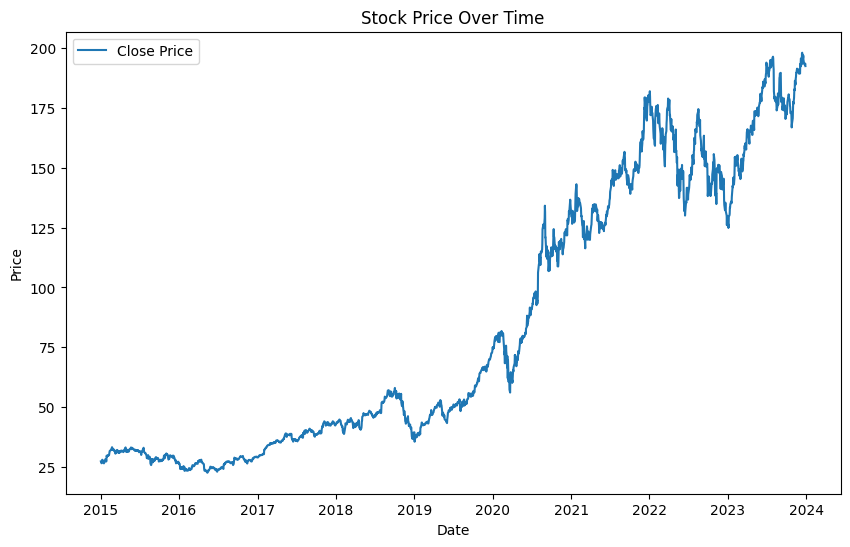

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Handle Missing Data
print("Missing values:\n", data.isnull().sum())

Missing values:
 Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64


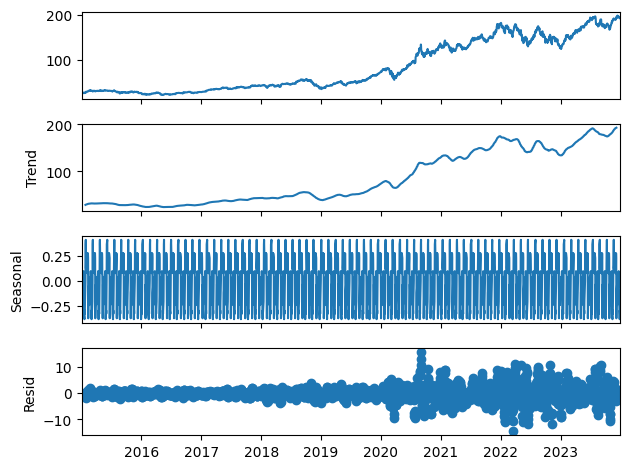

In [ ]:
# Analyze Trends and Patterns
result = seasonal_decompose(data['Close'], model='additive', period=30)
result.plot()
plt.show()

In [ ]:
# ARIMA Model
# Split Data
train = data['Close'][:int(0.8 * len(data))]
test = data['Close'][int(0.8 * len(data)):]

In [ ]:
# Build ARIMA Model
model_arima = ARIMA(train, order=(5, 1, 0))  # (p, d, q) parameters
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1811
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3266.402
Date:                Sat, 21 Dec 2024   AIC                           6544.804
Time:                        17:22:36   BIC                           6577.810
Sample:                             0   HQIC                          6556.985
                               - 1811                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0529      0.013     -4.139      0.000      -0.078      -0.028
ar.L2         -0.0005      0.012     -0.043      0.966      -0.024       0.023
ar.L3         -0.0391      0.014     -2.794      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


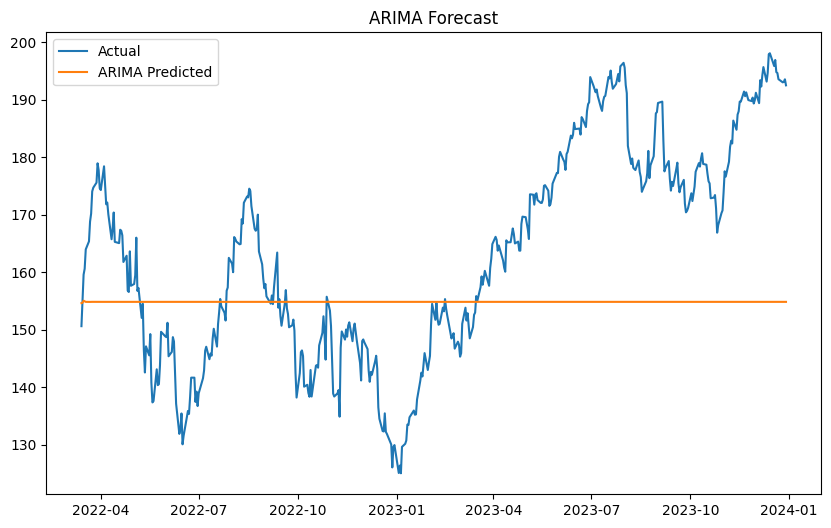

In [ ]:
# Forecast and Evaluate
forecast_arima = model_arima_fit.forecast(steps=len(test))
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Predicted')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
# Prepare Data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Build and Train LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, Y, epochs=20, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0493
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.6014e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 5.6952e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 5.8150e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 5.4617e-04
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 4.8388e-04
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 4.6508e-04
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.6331e-04
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.6424e-04
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 4.2420e-04
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 4.1468e-04
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.0999e-04
Epoch 13/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 4.3113e-04
Epoch 14/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.3369e-04
Epoch 15/20
69/69 ━

In [ ]:
# Step 8: Predict and Evaluate with LSTM
predictions_lstm = model_lstm.predict(X)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


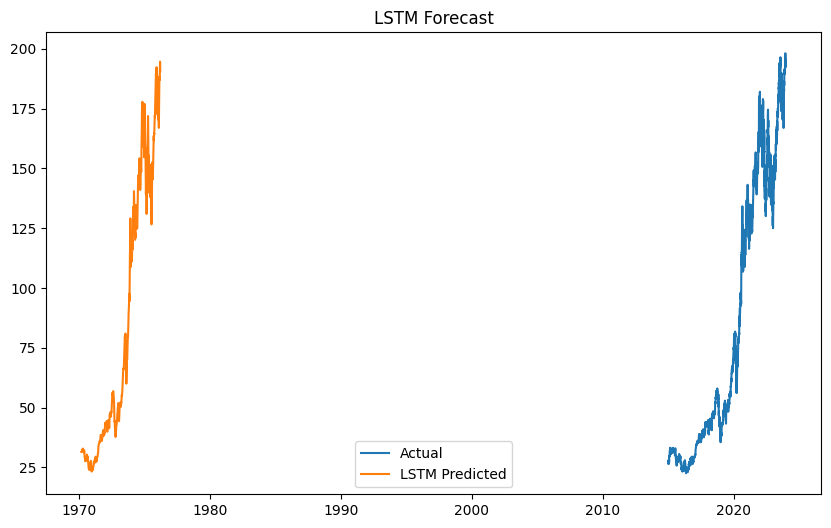

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(range(look_back, len(predictions_lstm) + look_back), predictions_lstm, label='LSTM Predicted')
plt.title('LSTM Forecast')
plt.legend()
plt.show()